# JPEG encoding

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as im
from skimage.util import view_as_windows
np.set_printoptions(suppress=True)

## Color space transformation (RGB -> YCbCr)

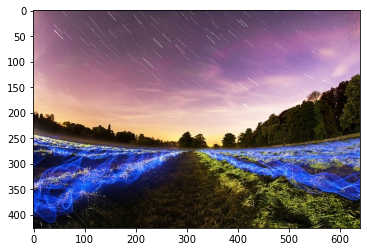

(426, 640, 3)


In [2]:
image = np.array(im.open('sample.bmp'))
plt.imshow(image)
plt.show()
print(image.shape)

In [3]:
# constants for transforming RGB to YCbCr color space
Kr = 0.299  # Kr + Kg + Kb = 1
Kg = 0.587
Kb = 0.114

def rgb2ycbcr(img):
    """
    Transforms image from RGB(A) color space to Y'CbCr color space
    :param img: image in RGB(A), np array (h, w, ch) (ch=3 -> RGB, ch=4 -> RGBA)
    :return: image in Y'CbCr (h, w, 3)
    """
    if img.shape[2] == 4:  # let's ignore the alpha values
        img = img[:, :, 0:3]

    coefficients = np.array([[Kr, Kg, Kb],  # https://en.wikipedia.org/wiki/YCbCr#YCbCr
                             [-0.5 * Kr / (1 - Kb), -0.5 * Kg / (1 - Kb), 0.5],
                             [0.5, -0.5 * Kg / (1 - Kr), -0.5 * Kb / (1 - Kr)]])
    YCbCr = np.dot(img, coefficients.T)
    YCbCr[:, :, 1:] += 128
    return np.uint8(YCbCr)



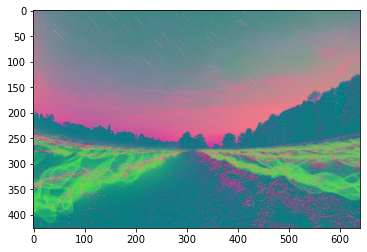

In [4]:
ycbcr = rgb2ycbcr(image)
plt.imshow(ycbcr)
plt.show()

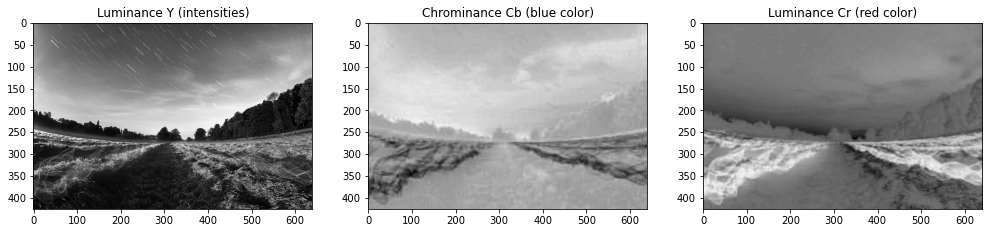

In [5]:
Y = im.fromarray(ycbcr[:,:,0], "L")
Cb = im.fromarray(ycbcr[:,:,1], "L")
Cr = im.fromarray(ycbcr[:,:,2], "L")
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17,10))
plt.subplot(1, 3, 1)
plt.title("Luminance Y (intensities)")
plt.imshow(Y,cmap="gray")
plt.subplot(1, 3, 2)
plt.title("Chrominance Cb (blue color)")
plt.imshow(Cr,cmap="gray")
plt.subplot(1, 3, 3)
plt.title("Luminance Cr (red color)")
plt.imshow(Cb,cmap="gray")
plt.show()

## Downsampling

In [6]:
def downsample(img, ratio=(2, 2), scikit=False):
    """
    Downsample the chroma channels of given image
    :param img: image in Y'CbCr color space, np array (h, w, ch)
    :param ratio: tuple indicating factor of downsampling in x and y directions
    :param scikit: use scikit library or for loops for downsampling, bool
    :return: list of np channels, where chroma channels are downsampled
    """

    h, w = img.shape[0], img.shape[1]
#     img = np.ones((h+1, w+1, 3))  # try image dimensions that are not divisible by downsmapling ratio
    Y = img[:, :, 0]
    Cb = img[:, :, 1]
    Cr = img[:, :, 2]

    shape = (int(h / ratio[0] + h % ratio[0]), int(w / ratio[1] + w % ratio[1]))  # desired output shape of chroma channels

    if not scikit:  # my slower version with for loops
        downsampled_Cb = np.zeros(shape)
        downsampled_Cr = np.zeros_like(downsampled_Cb)
        for i in range(0, h, ratio[0]):
            for j in range(0, w, ratio[1]):
                # do the downsampling by averaging the value of the pixels and rounding to the nearest integer
                downsampled_Cb[i // ratio[0], j // ratio[1]] = np.round(np.mean(Cb[i: i + ratio[0], j: j + ratio[1]])).astype(int)
                downsampled_Cr[i // ratio[0], j // ratio[1]] = np.round(np.mean(Cr[i: i + ratio[0], j: j + ratio[1]])).astype(int)

    else:  # vectorized, hence much faster version of downsampling with skicit-image library
        Cb_windows = view_as_windows(Cb, ratio, ratio)
        Cr_windows = view_as_windows(Cr, ratio, ratio)
        downsampled_Cb = np.round(np.mean(Cb_windows, axis=(2, 3))).astype(int)
        downsampled_Cr = np.round(np.mean(Cr_windows, axis=(2, 3))).astype(int)

    downsampled = [Y, downsampled_Cb, downsampled_Cr]

    return downsampled

In [7]:
import time
start_time = time.time()
downsampled = downsample(ycbcr, scikit=True)
print(time.time()-start_time)
print('Dimensions of the channels after downsampling: ', [i.shape for i in downsampled])

0.005963802337646484
Dimensions of the channels after downsampling:  [(426, 640), (213, 320), (213, 320)]


## Creating 8x8 blocks

In [8]:
def create_pixel_blocks(img):
    """
    Create list of blocks of size block_size x block_size from given image. pAdding is applied if necessary
    :param img: list (3) of channels, due to downsampling not all the channels have the same size
    :return: list of blocks shaped (8, 8, 3)
    """

    block_size = 8  # not as changeable parameter because our quantization tables are 8 x 8

    for i, channel in enumerate(img):
        h, w = channel.shape
        # padding at the end of image, we copy the values of last row/column in image remainder-times
        if h % block_size != 0:
            remainder = h % block_size
            last_row = channel[-1, :]
            to_add = np.tile(last_row, (remainder, 1))
            channel = np.concatenate((channel, to_add), axis=0)
        if w % block_size != 0:
            remainder = w % block_size
            last_col = channel[:, -1]
            to_add = np.tile(last_col[:, np.newaxis], (1, remainder))
            channel = np.concatenate((channel, to_add), axis=1)
        img[i] = channel

    pixel_blocks = []
    for channel in img:
        h, w = channel.shape
        pixel_block = []
        for i in range(int(h / block_size)):
            for j in range(int(w / block_size)):  # loop over the image and create the groups
                pixel_block.append(channel[i * block_size:(i + 1) * block_size, j * block_size: (j + 1) * block_size])
        pixel_blocks.append(pixel_block)

    return pixel_blocks

In [9]:
pixel_blocks = create_pixel_blocks(downsampled)
print([(len(i), i[0].shape) for i in pixel_blocks])

[(4240, (8, 8)), (1080, (8, 8)), (1080, (8, 8))]


## Discrete cosine transform
In JPEG coding we use DCT-II version of the discrete cosine transform. The DCT-II is probably the most commonly used form, and is often simply referred to as "the DCT". Its formula looks like this:
<center>$y_k = \frac{\alpha(k)}{2}\sum_{n=0}^{N-1} x_n \cos\left(\frac{\pi k(2n+1)}{2N} \right)$</center>

![Two-dimensional DCT frequencies](dct.png)

In [10]:
def precalculate_cos():
    N = 8
    table = np.zeros((8,8))
    for m in range(N):
        for i in range(N):
            table[m, i] = np.cos((np.pi * m * (2 * i + 1)) / (2 * N))
    return table

def dct_2d(pixel_blocks, table):
    step1 = np.apply_along_axis(dct_1d, axis=0, arr=pixel_blocks, table=table)
    step2 = np.apply_along_axis(dct_1d, axis=1, arr=step1, table=table)
    return step2


def dct_1d(pixel_blocks, table):
    N = pixel_blocks.shape[0]  # 8
    coefficients = np.zeros(N)
    for m in range(N):
        for i in range(N):
            coefficients[m] += pixel_blocks[i] * table[m,i]
        alpha = 1/np.sqrt(2) if m == 0 else 1
        coefficients[m] *= alpha
    return coefficients/2


def idct_2d(pixel_blocks, table):
    step1 = np.apply_along_axis(idct_1d, axis=0, arr=pixel_blocks, table=table)
    step2 = np.apply_along_axis(idct_1d, axis=1, arr=step1, table=table)
    return step2


def idct_1d(pixel_blocks, table):
    N = pixel_blocks.shape[0]  # 8
    coefficients = np.zeros(N)
    for m in range(N):
        for i in range(N):
            coefficients[m] += pixel_blocks[i] * table[i,m]
            alpha = 1/np.sqrt(2) if i == 0 else 1
            coefficients[m] *= alpha
    return coefficients/2


def discrete_cosine_transform(pixel_blocks, inverse=False):
    """
    Applies discrete cosine transform to pixel groups (8 x 8) in each channel
    :param pixel_blocks: list (3) of lists of blocks (8 x 8)
    :return: blocks with DCT values, same shape like pixel_blocks
    """
    transformed = []
    table = precalculate_cos()
    for channel in pixel_blocks:  # for each channel
        transformed_channel = []
        for block in channel:  # for each pixel block (8 x 8)
            if not inverse:
                shifted = block.astype(int)-128
                transformed_channel.append(dct_2d(shifted, table))  # perform DCT
            else:
                transformed_channel.append(idct_2d(block, table)+128)
        transformed.append(transformed_channel)
    return transformed

In [11]:
start_time = time.time()
transformed = discrete_cosine_transform(pixel_blocks)
print(time.time()-start_time)
print([(len(i), i[0].shape) for i in transformed])

13.25131344795227
[(4240, (8, 8)), (1080, (8, 8)), (1080, (8, 8))]


273 3 (426, 640, 3)
(8, 8)


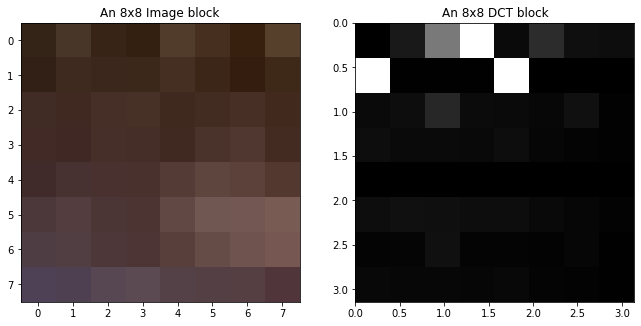

Values of the DCT block:
[[ 0.   -0.6  -2.83  5.89  0.25  1.03  0.36  0.3 ]
 [-7.8  -0.04  0.03 -0.03 -7.8  -0.02  0.01 -0.01]
 [ 0.23 -0.32 -0.91 -0.27  0.23 -0.18 -0.38 -0.06]
 [-0.32 -0.25  0.24 -0.21 -0.32 -0.14  0.1  -0.05]
 [-0.    0.   -0.   -0.   -0.   -0.   -0.    0.  ]
 [-0.31 -0.38  0.35 -0.32 -0.31 -0.21  0.15 -0.07]
 [-0.1   0.13  0.37  0.11 -0.1   0.08  0.16  0.03]
 [-0.19 -0.18  0.17 -0.16 -0.19 -0.1   0.07 -0.04]]


In [12]:
# Extract a block from image
pos = 264  # pixel block starting at (pos, pos) position in the image
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17,12))
plt.subplot(1, 3, 1)
plt.imshow(image[pos:pos+8,pos:pos+8],cmap='gray')
plt.title("An 8x8 Image block")

# Display the dct of that block
plt.subplot(1, 3, 2)
h, w, c = image.shape
list_pos = int(np.floor(pos/(w/8))*w/8 + pos/8)
print(list_pos, len(transformed), image.shape)
max_val = np.max(np.abs(transformed[0][list_pos]))
print(transformed[0][list_pos].shape)
block = transformed[0][list_pos]       
block[0,0] = 0
plt.imshow(np.abs(block),cmap='gray',vmax=np.max(block), vmin=0, extent=[0,np.pi,np.pi,0])
plt.title("An 8x8 DCT block")

plt.show()

np.set_printoptions(precision=2, suppress=True)
print('Values of the DCT block:')
print(transformed[0][list_pos])

## Quantization

In [13]:
# quantization matrices for quality of 50% (https://arxiv.org/pdf/1405.6147.pdf)
luma_quantization_table = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                                    [12, 12, 14, 19, 26, 58, 60, 55],
                                    [14, 13, 16, 24, 40, 57, 69, 56],
                                    [14, 17, 22, 29, 51, 87, 80, 62],
                                    [18, 22, 37, 56, 68, 109, 103, 77],
                                    [24, 35, 55, 64, 81, 104, 113, 92],
                                    [49, 64, 78, 87, 103, 121, 120, 101],
                                    [72, 92, 95, 98, 112, 100, 103, 99]]).astype(np.int32)

chroma_quantization_table = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
                                      [18, 21, 26, 66, 99, 99, 99, 99],
                                      [24, 26, 56, 99, 99, 99, 99, 99],
                                      [47, 66, 99, 99, 99, 99, 99, 99],
                                      [99, 99, 99, 99, 99, 99, 99, 99],
                                      [99, 99, 99, 99, 99, 99, 99, 99],
                                      [99, 99, 99, 99, 99, 99, 99, 99],
                                      [99, 99, 99, 99, 99, 99, 99, 99]]).astype(np.int32)

def quantize(blocks):
    """
    Quantize pixel blocks with given quantization tables
    :param blocks: list of 8x8 blocks of transformed values by DCT
    :return: list of quantized blocks
    """
    luma = luma_quantization_table
    chroma = chroma_quantization_table
    quantized = []
    for i, channel in enumerate(blocks):
        quantized_channel = []
        for block in channel:
            if i == 0:  # Y channel - we use luma quantization table
                block = np.round(block / luma)
            else:  # Cb or Cr channel - we use chroma quantization table
                block = np.round(block / chroma)
            quantized_channel.append(block)
        quantized.append(quantized_channel)
    return quantized

In [14]:
quantized = quantize(transformed)

## Dequantize

In [15]:
def dequantize(blocks):
    luma = luma_quantization_table
    chroma = chroma_quantization_table
    quantized = []
    for i, channel in enumerate(blocks):
        quantized_channel = []
        for block in channel:
            if i == 0:  # Y channel - we use luma quantization table
                block *= luma
            else:  # Cb or Cr channel - we use chroma quantization table
                block *= chroma
            quantized_channel.append(block)
        quantized.append(quantized_channel)
    return quantized

In [16]:
import copy
dequantized = dequantize(copy.deepcopy(quantized))

In [17]:
idcted = discrete_cosine_transform(dequantized, inverse=True)

## Upsampling
Upsample the chromatic channels in the most easy way, just copy the pixel by given ratio (this ratio should be the same for downsampling to get the correct result)

In [18]:
def upsample(blocks, image, ratio=(2,2)):
    block_size = 8
    h, w, c = image.shape
    rounded_w = int(np.ceil(w/block_size)*block_size)
    rounded_h = int(np.ceil(h/block_size)*block_size)
    new_img = np.zeros((rounded_h, rounded_w, c))
    for c, channel in enumerate(blocks):
        for i, block in enumerate(channel):
            if c == 0:
                y = (i*block_size//w)*block_size
                x = i*block_size%w
                end_y = y + block_size
                end_x = x + block_size
                new_img[y:end_y, x:end_x, c] = block
            else:
                y = (i*(block_size*ratio[0])//w)*block_size*ratio[0]
                x = i*(block_size*ratio[1])%w
                end_y = y + block_size*ratio[0]
                end_x = x + block_size*ratio[1]
                block = np.repeat(np.repeat(block, 2, axis=0), 2, axis=1)
                new_img[y:end_y, x:end_x, c] = block
    return new_img

In [19]:
upsampled = upsample(idcted, image)

## YCbCr -> RGB

In [20]:
def ycbcr2rgb(img):
    """
    Transform image in Y'CbCr color space to RGB color space
    :param img: image in Y'CbCr, np array (h, w, 3)
    :return: image in RGB color space, np array (h, w, 3)
    """
    coefficients = np.array([[1, 0, 2 - 2 * Kr],  # https://en.wikipedia.org/wiki/YCbCr#YCbCr
                             [1, -(Kb / Kg) * (2 - 2 * Kb), -(Kr / Kg) * (2 - 2 * Kr)],
                             [1, 2 - 2 * Kb, 0]])

    img = img.astype(np.float)
    img[:, :, 1:] -= 128
    rgb = np.dot(img, coefficients.T)
    rgb = np.where(rgb > 255, 255, rgb)
    rgb = np.where(rgb < 0, 0, rgb)
    return np.uint8(rgb)

In [21]:
rgb = ycbcr2rgb(upsampled)

## Final result

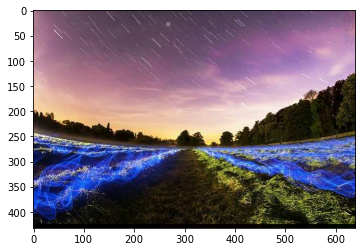

In [22]:
plt.imshow(rgb)
plt.show()

## Lossy compresion
As can be seen below, we lost some information from the image because of downsampling and quantization, that's why JPEG is a lossy compresion. But as shown above, we do not notice a difference between the compressed and original image when the picture is not zoomed in.

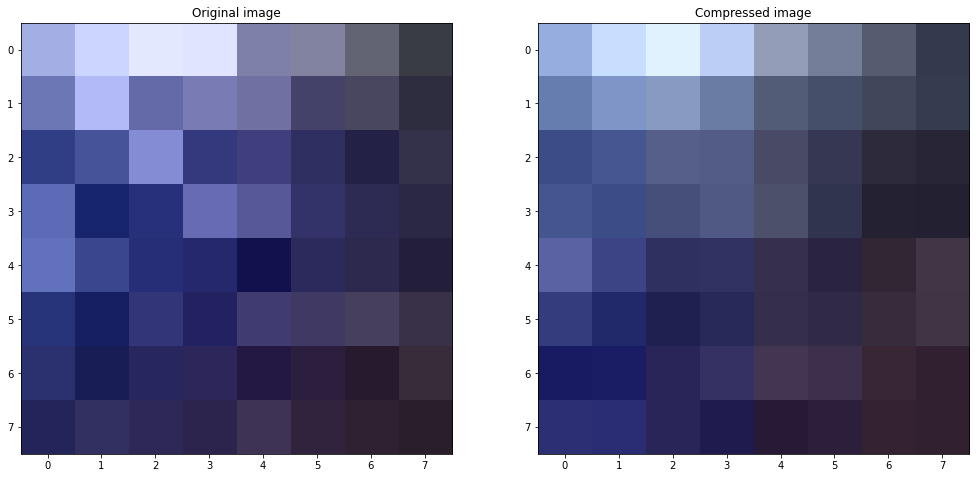

In [26]:
pos = 280
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17,12))
plt.subplot(1, 2, 1)
plt.imshow(image[pos:pos+8,pos:pos+8])
plt.title("Original image")
plt.subplot(1, 2, 2)
plt.imshow(rgb[pos:pos+8,pos:pos+8])
plt.title("Compressed image")
plt.show()